# ex014
5-fold  
img size 512

In [18]:
import gc
import os
import random
import time
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

# model
import torch
import torchvision
import torch.nn as nn
import timm
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms.functional as TF

# data loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

# training
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, ExponentialLR

# metric
from sklearn.metrics import fbeta_score, roc_auc_score

import wandb

# config

In [19]:
BASE_DIR = "/working/"
INPUT_DIR = os.path.join(BASE_DIR, "input", "vesuvius-challenge-ink-detection")
TRAIN_DIR = os.path.join(INPUT_DIR, "train")
TEST_DIR = os.path.join(INPUT_DIR, "test")
# IMG_SIZE = [256, 256]
# IMG_SIZE = [128, 128]
IMG_SIZE = [512, 512]
SURFACE_LIST = [
                range(26, 36, 3),
                range(27, 37, 3),                
                range(25, 35, 3),
                ]
print(len(SURFACE_LIST[0]))
print(SURFACE_LIST)

SURFACE_NUM = len(SURFACE_LIST[0])
# print("Start surface idx =",START_SURFACE)

# SLIDE_POS_LIST = [[idx*(IMG_SIZE[0]//6), idx*(IMG_SIZE[1]//6)] for idx in range(0, 3)]
# SLIDE_POS_LIST = [[0,0], [IMG_SIZE[0]//2, 0], [0, IMG_SIZE[1]//2], [IMG_SIZE[0]//2, IMG_SIZE[1]//2]]
SLIDE_POS_LIST = [[0,0], 
                  [0, IMG_SIZE[1]//3],
                  [0, IMG_SIZE[1]//3*2],
                  [IMG_SIZE[0]//3, 0], 
                  [IMG_SIZE[0]//3, IMG_SIZE[1]//3],
                  [IMG_SIZE[0]//3, IMG_SIZE[1]//3*2],
                  [IMG_SIZE[0]//3*2, 0],
                  [IMG_SIZE[0]//3*2, IMG_SIZE[1]//3],
                  [IMG_SIZE[0]//3*2, IMG_SIZE[1]//3*2],
                  ]

print("SLIDE_POS_LIST =", SLIDE_POS_LIST)
CFG = {
    "DEBUG" : False,
    # exp setting
    "EXP_CATEGORY" : "5fold",
    "EXP_NAME" : "exp068",
    "folds" : [0, 1, 2, 3, 4],

    # model
    # "model_name" : "tf_efficientnet_b0",
    "model_name" : "tf_efficientnet_b6",
    "inp_channels" : SURFACE_NUM,
    "out_channels" : 1,
    "pretrained" : True,
    "out_indices" : [0,1,2,3,4],
 
    # data   
    "img_size": IMG_SIZE,
    "batch_size": 32,
    # "batch_size": 16,#batch normの関係か？16の方が64より安定してそう？？
    # "batch_size": 8,
    "INPUT_DIR": INPUT_DIR,
    "TRAIN_DIR": TRAIN_DIR,
    "TEST_DIR": TEST_DIR,
    "surface_num": SURFACE_NUM,
    "surface_list": SURFACE_LIST,
    "slide_pos_list": SLIDE_POS_LIST,
#     "surface_start_idx": START_SURFACE,
    # "TRAIN_DIR_LIST": [["1", "2"], ["1", "3"], ["2", "3"]],
    "TRAIN_DIR_LIST": [["1", "2_0", "2_1", "2_2"], 
                       ["1", "2_0", "2_1", "3"],
                       ["1", "2_0",  "2_2", "3"],
                       ["1", "2_1", "2_2", "3"],
                       ["2_0", "2_1", "2_2", "3"],
                       ],
#     "TRAIN_IDX_LIST" : ["1"],
    # "VALID_DIR_LIST": [["3"],["2"],["1"]],
    "VALID_DIR_LIST": [["3"], ["2_2"], ["2_1"], ["2_0"],["1"]],
    "TEST_DIR_LIST": ["a", "b"],

    # learning
    "n_epoch" : 10,
    "lr" : 1e-3,
    "T_max" : 5,
    "min_lr" : 1e-8,
    "weight_decay" : 1e-6,

    # etc
    "print_freq" : 1000,
    "random_seed" : 21,
    "num_workers": 2,
}


if CFG["model_name"]=="tf_efficientnet_b0":
    CFG["channel_nums"] = [320, 112, 40, 24, 16]
elif CFG["model_name"]=="tf_efficientnet_b4":
    CFG["channel_nums"] = [448, 160, 56, 32, 24]
elif CFG["model_name"]=="tf_efficientnet_b6":
    CFG["channel_nums"] = [576, 200, 72, 40, 32]


if CFG["DEBUG"]:
    CFG["n_epoch"] = 1
    CFG["EXP_NAME"] = "DEBUG"
    

CFG["OUTPUT_DIR"] = os.path.join(BASE_DIR, "output", CFG["EXP_NAME"])

4
[range(26, 36, 3), range(27, 37, 3), range(25, 35, 3)]
SLIDE_POS_LIST = [[0, 0], [0, 170], [0, 340], [170, 0], [170, 170], [170, 340], [340, 0], [340, 170], [340, 340]]


# utils

In [20]:
def seed_everything(seed=CFG["random_seed"]):
    #os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic =True
    torch.backends.cudnn.benchmark = False
seed_everything()

# device optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [21]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# metric

In [22]:
def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta_auc(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    dice_list = [] 
    # for th in np.array(range(10, 50+1, 5)) / 100:
    for th in np.array(range(10, 100+1, 5)) / 100:
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice_list.append(dice)
        # print(f'\t th: {th}, fbeta: {dice}')
        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    auc = roc_auc_score(mask, mask_pred)
    # Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th, auc, dice_list


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th, auc, dice_list = calc_fbeta_auc(mask_gt, mask_pred)

    return best_dice, best_th, auc, dice_list

# model

In [23]:
class Encoder(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = timm.create_model(CFG["model_name"], in_chans=CFG["inp_channels"], features_only=True, out_indices=CFG["out_indices"], pretrained=CFG["pretrained"])
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        return skip_connection_list

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.up(x)
        x = self.bn1(x)
        x = self.conv(x)
        x = self.bn2(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.UpConv_0 = UpConv(CFG["channel_nums"][0], CFG["channel_nums"][1])
        self.UpConv_1 = UpConv(CFG["channel_nums"][1]*2, CFG["channel_nums"][2])
        self.UpConv_2 = UpConv(CFG["channel_nums"][2]*2, CFG["channel_nums"][3])
        self.UpConv_3 = UpConv(CFG["channel_nums"][3]*2, CFG["channel_nums"][4])
    
    def forward(self, skip_connection_list):
        emb = self.UpConv_0(skip_connection_list[4]) # emb.shape = (None, 160, 14, 14)
        emb_cat = torch.cat([skip_connection_list[3], emb], dim = 1)
        
        emb = self.UpConv_1(emb_cat)
        emb_cat = torch.cat([skip_connection_list[2], emb], dim = 1)
        
        emb = self.UpConv_2(emb_cat)
        emb_cat = torch.cat([skip_connection_list[1], emb], dim = 1)
        
        emb = self.UpConv_3(emb_cat)
        emb_cat = torch.cat([skip_connection_list[0], emb], dim = 1)

        return emb_cat

class SegModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.encoder = Encoder(CFG)
        self.decoder = Decoder()
        self.head = nn.Sequential(
            nn.Conv2d(CFG["channel_nums"][-1], CFG["out_channels"], kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )
    def forward(self, img):
        skip_connection_list = self.encoder(img)
        emb = self.decoder(skip_connection_list)
        output = self.head(emb)
        return output

# Dataset

In [24]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(int(CFG["img_size"][0]*0.8), int(CFG["img_size"][1]*0.8), p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    A.Resize(CFG["img_size"][0], CFG["img_size"][1]),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    ToTensorV2(),
])

In [25]:
def fft_transform(img):
    eps = 1e-7
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift = np.nan_to_num(fshift)+eps#nanを0埋め
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

def highpass_filter(img):
    frange = 1
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2

    # create a mask first, center square is 1, remaining all zeros
    mask = np.ones((rows,cols,2),np.uint8)
    mask[crow-frange:crow+frange, ccol-frange:ccol+frange] = 0

    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    return img_back

def lowpass_filter(img):
    frange = 5
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img.shape
    crow,ccol = rows//2 , cols//2

    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows,cols,2),np.uint8)
    mask[crow-frange:crow+frange, ccol-frange:ccol+frange] = 1

    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

    return img_back

In [26]:
class VCID_Dataset(Dataset):
    def __init__(self, CFG, data_dir_list, surface_list, surface_volumes=None, slide_pos=[0,0], mode="train", transform=None):
        # get config
        self.mode = mode
        self.img_size = CFG["img_size"]
        if self.mode=="train":  self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode=="valid":    self.DATADIR = CFG["TRAIN_DIR"]
        elif self.mode == "test":   self.DATADIR = CFG["TEST_DIR"]
        self.data_dir_list = data_dir_list
        self.surface_list = surface_list
        self.slide_pos = slide_pos
        self.transform = transform
        
        # get imgs
        # print("initializing dataset...")
        self.imgs = []
        for data_dir in self.data_dir_list:
            img_path = os.path.join(self.DATADIR, data_dir, "mask.png")
            # print(img_path)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = img.reshape(img.shape[0], img.shape[1], 1) # (h, w, channel=1)
            self.imgs.append(img)
        
        # check imgs
        for img in self.imgs:
            assert img is not None, "img is None. data path is wrong"
        # get and split surface
        if surface_volumes is None:
            self.surface_vols = self.read_surfacevols()
        else:
            # print("using loaded surface_vols")
            self.surface_vols = surface_volumes
        for surface_vol in self.surface_vols:
            assert surface_vol is not None, "surface_vol is None. data path is wrong"
       
        # split grid
        self.get_all_grid()
        self.fileter_grid()
        self.get_flatten_grid()
        # print("split grid done.") 
       
        # get label imgs
        if self.mode == "train" or self.mode == "valid":
            self.labels = []
            for data_dir in self.data_dir_list:
                label_path = os.path.join(self.DATADIR, data_dir, "inklabels.png")
                assert os.path.exists(label_path), f"{label_path} is not exist."
                
                # read label
                label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
                # mask erosion
                kernel_size = (img.shape[0]+img.shape[1])//2//100
                kernel = np.ones((kernel_size, kernel_size), np.uint8)
                img = cv2.erode(img, kernel,iterations = 3)
                
                label = label.reshape(label.shape[0], label.shape[1], 1) # (h, w, channel=1)
                self.labels.append(label)# 画像サイズがそれぞれ違うので単純にconcatできずlist化しているs
        # print("initializing dataset done.")

    def get_surface_volumes(self):
        return self.surface_vols

    def read_surfacevols(self):
        """ read surface volume by data_dir_list and surface_list 
            Returns:surface_vuls (list): surface volume list [array(h,w,channel=surface_num), array(), ...]
        """
        surface_vols = []
        # print("reading surface volume...")
        for data_dir in self.data_dir_list:
            surface_vol_ = None
            for read_idx, surface_idx in enumerate(self.surface_list):
                # print("\r", f"reading idx : {read_idx+1}/{len(self.surface_list)}", end="")
                surface_path = os.path.join(self.DATADIR, data_dir, "surface_volume", f"{surface_idx:02}.tif")
                surface_vol = cv2.imread(surface_path, cv2.IMREAD_GRAYSCALE)
                surface_vol = surface_vol.reshape(surface_vol.shape[0], surface_vol.shape[1], 1) # (h, w, channel=1)
                if surface_vol_ is None:
                    surface_vol_ = surface_vol
                else:
                    surface_vol_ = np.concatenate([surface_vol_, surface_vol], axis=2) # (h, w, channel=surface_num)
            surface_vols.append(surface_vol_)
            # print(f"  => read surface volume done. [{data_dir}]")
        return surface_vols


    def get_grid_img(self, img, grid_idx):
        """ crop grid img from original img"""
        img_grid = img[grid_idx[0]*self.img_size[0] + self.slide_pos[0] : (grid_idx[0]+1)*self.img_size[0] + self.slide_pos[0],
                        grid_idx[1]*self.img_size[1] + self.slide_pos[1] : (grid_idx[1]+1)*self.img_size[1] + self.slide_pos[1]]
        return img_grid
    
    
    def get_masked_img(self, img, mask):
        """ multiply mask to surface_volumes """
        masked_img = None
        for channel in range(img.shape[2]):
            img_channel = img[:,:,channel].reshape(img.shape[0], img.shape[1],1)
            masked = img_channel*mask
            if masked_img is None:
                masked_img = masked.reshape(masked.shape[0], masked.shape[1], 1)
            else:
                masked = masked.reshape(masked.shape[0], masked.shape[1], 1)
                masked_img = np.concatenate([masked_img, masked], axis=2)
        return masked_img
    
    def get_grid_hpfimg(self, img, grid_idx):
        """ crop grid img from original img and hpf filter """
        img_grid = self.get_grid_img(img, grid_idx)
        img_transformed = None
        for channel in range(img_grid.shape[2]):
            img_grid_trans = highpass_filter(img_grid[:,:,channel])
            if img_transformed is None:
                img_transformed = img_grid_trans.reshape(img_grid_trans.shape[0], img_grid_trans.shape[1], 1)
            else:
                img_transformed = np.concatenate([img_transformed, img_grid_trans.reshape(img_grid_trans.shape[0], img_grid_trans.shape[1], 1)], axis=2)
        return img_transformed
    
    def get_all_grid(self):
        """ get all grid indices by img size and grid size
        """
        self.grid_indices = []
        for img in self.imgs:
            self.x_grid_size = (img.shape[0] - self.slide_pos[0]) // self.img_size[0]
            self.y_grid_size = (img.shape[1] - self.slide_pos[1]) // self.img_size[1]
            grid_img = []
            for i in range(self.x_grid_size):
                for j in range(self.y_grid_size):
                    grid_img.append([i, j])
            self.grid_indices.append(grid_img)
        return self.grid_indices
          
    def fileter_grid(self):
        """ get grid indices which mask is not 0 by all grid indices"""
        grid_indices_all = []
        for img, grid_indices in zip(self.imgs, self.grid_indices):
            grid_indices_copy = grid_indices.copy()
            for grid_idx in grid_indices:
                img_grid = self.get_grid_img(img, grid_idx)
                if img_grid.sum() == 0:
                    grid_indices_copy.remove(grid_idx)
            grid_indices_all.append(grid_indices_copy)
        self.grid_indices = grid_indices_all
        return self.grid_indices

    def get_flatten_grid(self):
        """ get flatten index list by grid indices
            Returns:flatten_grid (list): flatten index list [[img_idx, grid_idx], [img_idx, grid_idx], ...]
        """
        flatten_grid = []
        for img_idx, grid_indices in enumerate(self.grid_indices):
            for grid_idx in grid_indices:
                grid_imgidx_list = [img_idx]
                grid_imgidx_list.extend(grid_idx)
                flatten_grid.append(grid_imgidx_list)
        self.flatten_grid = flatten_grid
        return self.flatten_grid

    def __len__(self):
        return len(self.flatten_grid)

    def __getitem__(self, idx):
        # get indices
        img_grid_idx = self.flatten_grid[idx]
        img_idx = img_grid_idx[0]
        grid_idx = img_grid_idx[1:]
        # get img & surface_vol
        img = self.imgs[img_idx]
        surface_vol = self.surface_vols[img_idx]
        img = self.get_grid_img(img, grid_idx)/255.
        surface_vol = self.get_grid_img(surface_vol, grid_idx)/255.
        
        # multiple small mask 
        surface_vol = self.get_masked_img(surface_vol, img)
        assert surface_vol.shape[0]==img.shape[0] and surface_vol.shape[1]==img.shape[1] , "surface_vol_list shape is not same as img shape"
        img = surface_vol

        # transform
        if self.mode == "test":
            if self.transform:
                img = self.transform(image=img)["image"]
            else:
                img = img.transpose(2, 0, 1)
                img = torch.tensor(img, dtype=torch.float32)
            return img, grid_idx
        elif self.mode == "train" or self.mode=="valid":
            # get label(segmentation mask)
            label = self.labels[img_idx]
            label = self.get_grid_img(label, grid_idx)
            if self.transform:
                transformed = self.transform(image=img, mask=label)
                img = transformed["image"]
                label = transformed["mask"]
                label = label.permute(2, 0, 1)/255. # (channel, h, w)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            else:
                img = img.transpose(2, 0, 1) # (channel, h, w)
                label = label.transpose(2, 0, 1)/255. # (channel, h, w){}
                img = torch.tensor(img, dtype=torch.float32)
                label = torch.tensor(label, dtype=torch.float32)
                # label = TF.resize(img=label, size=(self.img_size[0]//2, self.img_size[1]//2))
            return img, label, grid_idx


# train valid fn

In [27]:
def train_fn(train_loader, model, criterion, epoch ,optimizer, scheduler):
    model.train()
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, _) in enumerate(train_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()     
        preds = model(images)
        
        # preds = torch.sigmoid(preds)
        loss = criterion(preds, targets)
        
        losses.update(loss.item(), CFG["batch_size"]) 
        targets = targets.detach().cpu().numpy().ravel().tolist()
        preds = preds.detach().cpu().numpy().ravel().tolist()
        loss.backward() # パラメータの勾配を計算
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
                
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                        epoch, batch_idx, len(train_loader), batch_time=batch_time, loss=losses,
                        remain=timeSince(start, float(batch_idx+1)/len(train_loader)),
            ))
        del preds, images, targets
    gc.collect()
    torch.cuda.empty_cache()
    return losses.avg

In [28]:
def valid_fn(model, valid_loader, criterion=None):
    model.eval()# モデルを検証モードに設定
    test_targets = []
    test_preds = []
    test_grid_idx = []
    batch_time = AverageMeter()
    losses = AverageMeter()
    start = end = time.time()
    for batch_idx, (images, targets, grid_idx) in enumerate(valid_loader):
        images = images.to(device, non_blocking = True).float()
        targets = targets.to(device, non_blocking = True).float()
        with torch.no_grad():
            preds = model(images)
            if not criterion is None:
                loss = criterion(preds, targets)
        if not criterion is None:
            losses.update(loss.item(), CFG["batch_size"])
        batch_time.update(time.time() - end)

        targets = targets.detach().cpu().numpy()
        preds = preds.detach().cpu().numpy()
        
        test_preds.extend([preds[idx, :,:,:].transpose(1,2,0) for idx in range(preds.shape[0])])
        test_targets.extend([targets[idx, :,:,:].transpose(1,2,0) for idx in range(targets.shape[0])])
        test_grid_idx.extend([[x_idx, y_idx] for x_idx, y_idx in zip(grid_idx[0].tolist(), grid_idx[1].tolist())])

        if (batch_idx % CFG["print_freq"] == 0 or batch_idx == (len(valid_loader)-1)) and (not criterion is None):
            print('EVAL: [{0}/{1}] '
                'Elapsed {remain:s} '
                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                .format(
                    batch_idx, len(valid_loader), batch_time=batch_time, loss=losses,
                    remain=timeSince(start, float(batch_idx+1)/len(valid_loader)),
                ))
        del preds, images, targets
        gc.collect()
        torch.cuda.empty_cache()
    if criterion is None:
        return test_targets, test_preds, test_grid_idx
    else:
        return test_targets, test_preds, test_grid_idx, losses.avg

# training loop

In [29]:
def concat_grid_img(img_list, label_list, grid_idx_list, valid_dir_list, slide_pos=[0,0], tta="default"):
    # concat pred img and label to original size
    img_path = os.path.join(CFG["TRAIN_DIR"], valid_dir_list[0], "mask.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    pred_img = np.zeros_like(img).astype(np.float32)
    label_img = np.zeros_like(img).astype(np.float32)
    for img_idx, grid_idx in enumerate(grid_idx_list):
        if tta=="default":
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += img_list[img_idx]
            label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += label_list[img_idx]
        elif tta=="vflip":
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += np.flipud(img_list[img_idx])
            label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += np.flipud(label_list[img_idx])
        elif tta=="hflip":
            pred_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += np.fliplr(img_list[img_idx])
            label_img[grid_idx[0]*CFG["img_size"][0]+slide_pos[0] : (grid_idx[0]+1)*CFG["img_size"][0]+slide_pos[0],
                    grid_idx[1]*CFG["img_size"][1]+slide_pos[1] : (grid_idx[1]+1)*CFG["img_size"][1]+slide_pos[1], :] += np.fliplr(label_list[img_idx])

    return pred_img, label_img

In [30]:
def save_and_plot_oof(mode, fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary):
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_pred_img.png"), valid_preds_img*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_predbin_img.png"), valid_preds_binary*255)
    cv2.imwrite(os.path.join(CFG["OUTPUT_DIR"], "imgs", f"fold{fold}_{mode}_slice{slice_idx}_valid_targets_img.png"), valid_targets_img*255)
                

# slice inference

In [31]:
def get_tta_aug(aug_type):
    if aug_type=="default":
        return A.Compose([ToTensorV2(),])
    elif aug_type=="hflip":
        return A.Compose([
            A.HorizontalFlip(p=1.0),
            ToTensorV2(),
        ])
    elif aug_type=="vflip":
        return A.Compose([
            A.VerticalFlip(p=1.0),
            ToTensorV2(),
        ])
    else:
        return A.Compose([ToTensorV2(),])
        

In [32]:
def slide_inference(CFG, tta_list):
    start_time = time.time()
    slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list = [], [], []
    for fold in CFG["folds"]:
        print(f"-- fold{fold} slide inference start --")
 
        # set model & learning fn
        model = SegModel(CFG)
        model_path = os.path.join(CFG["OUTPUT_DIR"], f'{CFG["model_name"]}_auc_fold{fold}.pth')
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        valid_img_slice = None
        for slice_idx, surface_list in enumerate(CFG["surface_list"]):
            print("surface_list: ", surface_list)
            surface_volumes = None
            for slide_pos in CFG["slide_pos_list"]:
                print("slide pos:", slide_pos)
                valid_dirs = CFG["VALID_DIR_LIST"][fold]
                for tta in tta_list:
                    print(f"tta:{tta}")
                    valid_transforms = get_tta_aug(tta)
                    valid_dataset = VCID_Dataset(CFG, valid_dirs, surface_list, surface_volumes, slide_pos,
                                                 mode="valid", transform=valid_transforms)
                    surface_volumes = valid_dataset.get_surface_volumes()
                    valid_loader = DataLoader(valid_dataset, batch_size=CFG["batch_size"], shuffle = False,
                                                num_workers = CFG["num_workers"], pin_memory = True)

                    valid_targets, valid_preds, valid_grid_idx = valid_fn(model, valid_loader)

                    # target, predをconcatして元のサイズに戻す
                    valid_preds_img, valid_targets_img  = concat_grid_img(valid_preds, valid_targets, valid_grid_idx, valid_dirs, slide_pos, tta)
                    valid_score, valid_threshold, auc, dice_list = calc_cv(valid_targets_img, valid_preds_img)
                    valid_preds_binary = (valid_preds_img > valid_threshold).astype(np.uint8)
                    save_and_plot_oof("slide_tta", fold, slice_idx, valid_preds_img, valid_targets_img, valid_preds_binary) 

                    elapsed = time.time() - start_time
                    print(f"\t score:{valid_score:.4f}(th={valid_threshold:3f}), auc={auc:4f}::: time:{elapsed:.2f}s")
                    if valid_img_slice is None:
                        valid_img_slice = valid_preds_img
                    else:
                        valid_img_slice += valid_preds_img

        valid_img_slice /= len(CFG["surface_list"])*len(CFG["slide_pos_list"])*len(tta_list)
        valid_sliceave_score, valid_sliceave_threshold, ave_auc, dice_list = calc_cv(valid_targets_img, valid_img_slice)
        
        slice_ave_score_list.append(valid_sliceave_score)
        slice_ave_auc_list.append(ave_auc)
        slice_ave_score_threshold_list.append(valid_sliceave_threshold)

        valid_slice_binary = (valid_img_slice > valid_sliceave_threshold).astype(np.uint8)
        save_and_plot_oof("average_tta", fold, 555, valid_img_slice, valid_targets_img, valid_slice_binary)
        print(f'[fold{fold}] slice ave score:{valid_sliceave_score:.4f}(th={valid_sliceave_threshold:3f}), auc={ave_auc:4f}')
         
        del model, valid_loader, valid_dataset, valid_preds_img, valid_targets_img, valid_preds_binary
        gc.collect()
        torch.cuda.empty_cache()
    return slice_ave_score_list, slice_ave_auc_list, slice_ave_score_threshold_list


# main

---
# OOF SCORE INFER

In [33]:
# %%time
# tta_list = ["default", "hflip", "vflip"]
# slice_ave_score_list, slice_ave_score_threshold_list, slice_ave_auc_list, = slide_inference(CFG, tta_list)
# for fold in CFG["folds"]:
#     print(f"fold[{fold}] slice ave score:{slice_ave_score_list[fold]:.4f}(th={slice_ave_score_threshold_list[fold]:3f}), auc={slice_ave_auc_list[fold]:4f}")

/working/output/exp068/imgs/fold0_average_slice555_valid_pred_img.png
(7606, 5249)
(7606, 5249)


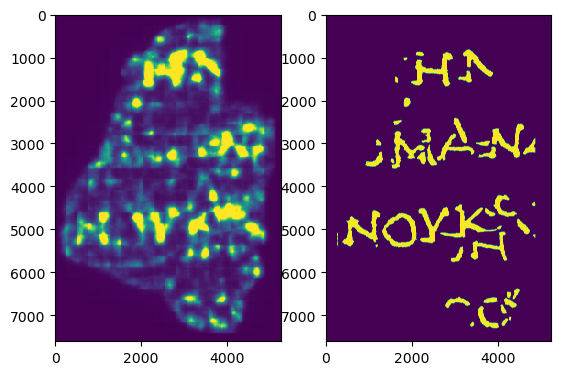

/working/output/exp068/imgs/fold1_average_slice555_valid_pred_img.png
(4944, 9506)
(4944, 9506)


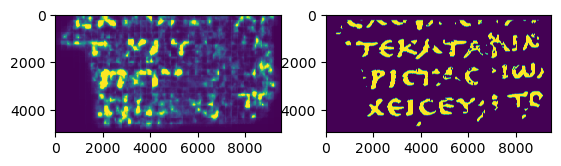

/working/output/exp068/imgs/fold2_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


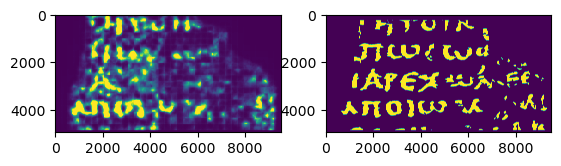

/working/output/exp068/imgs/fold3_average_slice555_valid_pred_img.png
(4943, 9506)
(4943, 9506)


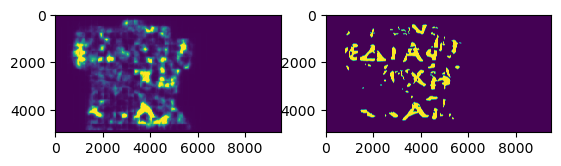

/working/output/exp068/imgs/fold4_average_slice555_valid_pred_img.png
(8181, 6330)
(8181, 6330)


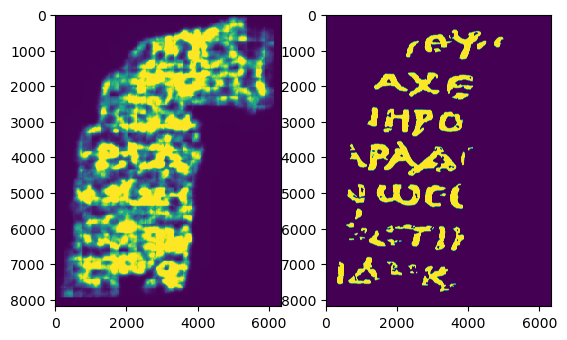

CPU times: user 16.5 s, sys: 5.9 s, total: 22.4 s
Wall time: 22.5 s


In [34]:
%%time
OUTPUT_DIR = CFG["OUTPUT_DIR"]
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    print(pred_path)
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape) 
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

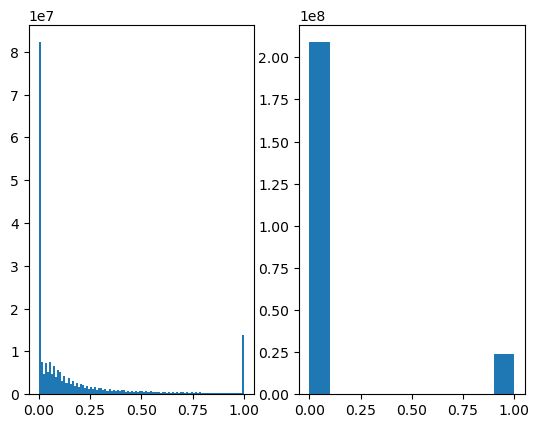

th=0.10, dice=0.2644
th=0.15, dice=0.3023
th=0.20, dice=0.3314
th=0.25, dice=0.3584
th=0.30, dice=0.3807
th=0.35, dice=0.3995
th=0.40, dice=0.4148
th=0.45, dice=0.4300
th=0.50, dice=0.4439
th=0.55, dice=0.4563
th=0.60, dice=0.4661
th=0.65, dice=0.4756
th=0.70, dice=0.4843
th=0.75, dice=0.4923
th=0.80, dice=0.4988
th=0.85, dice=0.5048
th=0.90, dice=0.5097
th=0.95, dice=0.5135
th=1.00, dice=0.5157


In [35]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")

(7606, 5249)
(7606, 5249)


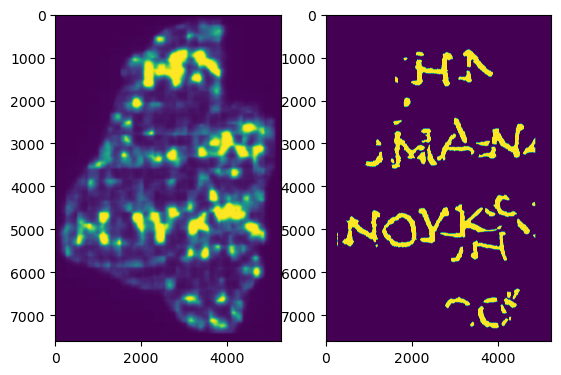

(4944, 9506)
(4944, 9506)


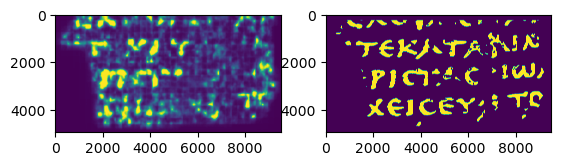

(4943, 9506)
(4943, 9506)


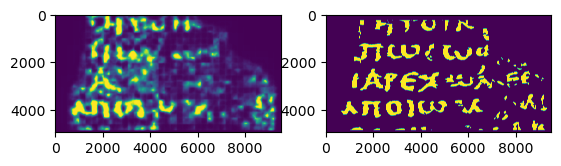

(4943, 9506)
(4943, 9506)


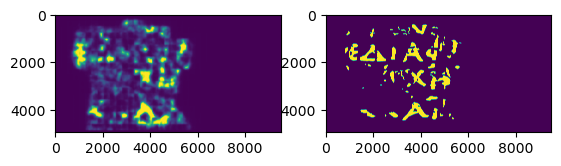

(8181, 6330)
(8181, 6330)


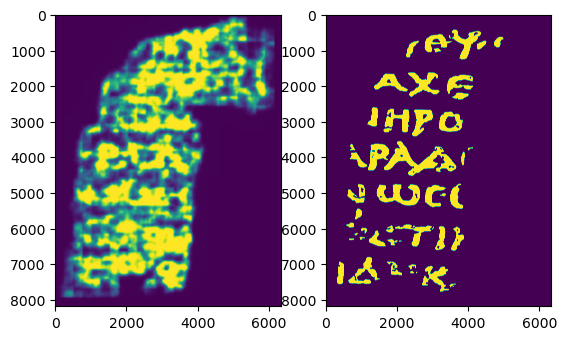

CPU times: user 21.5 s, sys: 6.4 s, total: 27.9 s
Wall time: 25.2 s


In [38]:
%%time
pred_flatten_list = []
mask_flatten_list = []
for fold in [0,1,2,3,4]:
    pred_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_pred_img.png")
    mask_path = os.path.join(OUTPUT_DIR, "imgs", f"fold{fold}_average_slice555_valid_targets_img.png")
    pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    pred_img = cv2.GaussianBlur(pred_img, (65, 65), 32)
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(pred_img.shape) 
    print(mask_img.shape)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(pred_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)
    plt.show()
    pred_flatten_list.extend(pred_img.flatten())
    mask_flatten_list.extend(mask_img.flatten())

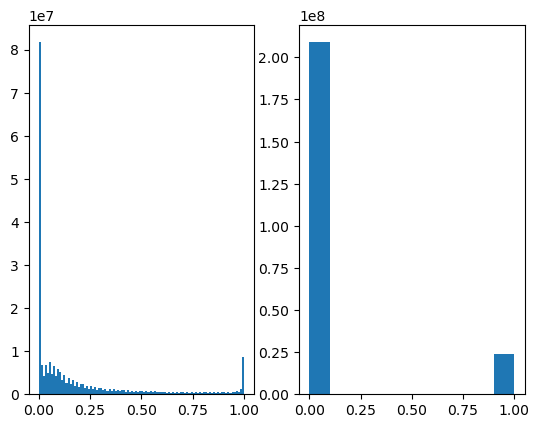

th=0.10, dice=0.2613
th=0.15, dice=0.2990
th=0.20, dice=0.3282
th=0.25, dice=0.3548
th=0.30, dice=0.3777
th=0.35, dice=0.3971
th=0.40, dice=0.4128
th=0.45, dice=0.4286
th=0.50, dice=0.4429
th=0.55, dice=0.4554
th=0.60, dice=0.4659
th=0.65, dice=0.4758
th=0.70, dice=0.4847
th=0.75, dice=0.4933
th=0.80, dice=0.5002
th=0.85, dice=0.5057
th=0.90, dice=0.5080
th=0.95, dice=0.5049
th=1.00, dice=0.4606


In [39]:
mask_flatten_list = np.array(mask_flatten_list)/255.
mask = np.array(mask_flatten_list).astype(int)
pred = np.array(pred_flatten_list)/255.

plt.figure()
plt.subplot(1, 2, 1)
plt.hist(pred, bins=100)
plt.subplot(1, 2, 2)
plt.hist(mask)
plt.show()

for th in np.array(range(10, 100+1, 5)) / 100:
    dice = fbeta_numpy(mask, (pred >= th).astype(int), beta=0.5)
    print(f"th={th:.2f}, dice={dice:.4f}")